In [8]:
pass_list = [0,0,0,0,0]
# pass_list = [0]

### 常見錯誤:
### too much error segment: please face the microphone


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
a 分析結果:
最低音限制(< 28 ): 26.059 pass
最高音限制(> 38 ): 39.661 pass


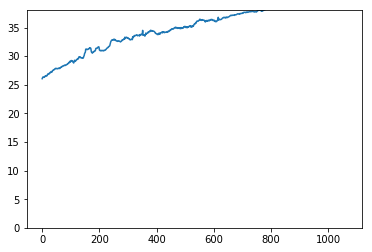

del_note(<= 0.35 ): 0.2843332901505029 pass
del_sp(< 1e-06 ): 3.775072153587547e-09 pass
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
i 分析結果:
最低音限制(< 28 ): 26.195 pass
最高音限制(> 38 ): 40.962 pass
include 2.wav


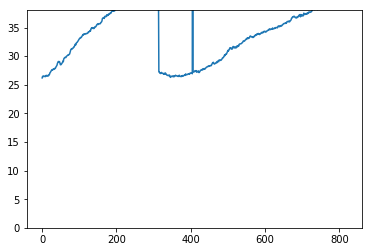

del_note(<= 0.35 ): 0.20627218730530927 pass
del_sp(< 1e-06 ): 5.489100442040058e-10 pass
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
u 分析結果:
最低音限制(< 28 ): 23.961 pass
最高音限制(> 38 ): 39.18 pass


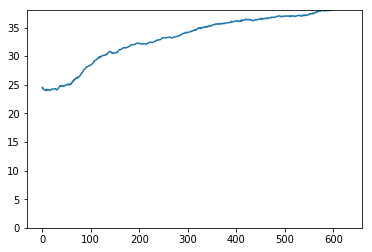

del_note(<= 0.35 ): 0.22934656129325148 pass
del_sp(< 1e-06 ): 1.4391109586258217e-10 pass
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
e 分析結果:
最低音限制(< 28 ): 23.456 pass
最高音限制(> 38 ): 39.274 pass


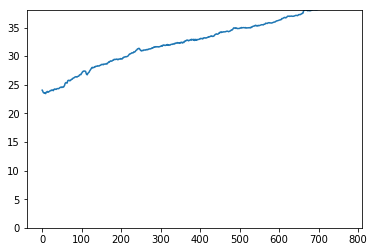

del_note(<= 0.35 ): 0.346138512095969 pass
del_sp(< 1e-06 ): 1.6188510415479125e-07 pass
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
o 分析結果:
最低音限制(< 28 ): 24.444 pass
最高音限制(> 38 ): 38.001 pass


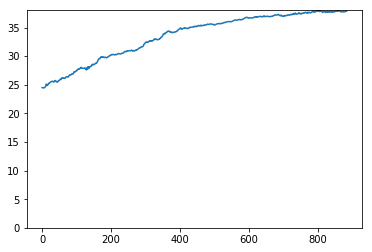

del_note(<= 0.35 ): 0.23654807242243692 pass
del_sp(< 1e-06 ): 8.181261234710227e-10 pass
==================結果===================
恭喜! 您的音檔可以使用，感謝您的配合!


In [9]:
# pass_list = [0,0,0,0,0]
from termcolor import colored
import sys
import numpy as np

import matplotlib.pyplot as plt
import os.path

import soundfile as sf
# import librosa
import pyworld as pw
def reset_fail_f0(f0):
    for j in range(1,len(f0)-1):
        if f0[j] ==  0:
            f0[j] = 2048*440
    return f0
#28 38 9 男
#32 42 9 女

frame_period = 10.0 # millisecond
samples_per_frame = int(np.floor(44100.0 * frame_period/1000.0))

aiueo = ['a','i','u','e','o']
isMale = 1
if isMale:
    note_lower,note_upper = 28,38
else:
    note_lower,note_upper = 32,42

max_del_note = 0.35
del_sp_upper = 0.000001  #1.7

for i in range(len(aiueo)):
    if pass_list[i]:
        print(aiueo[i] , "pass")
        continue
    isPass = True
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    file_cnt = 2
    wavname = 'data/'+aiueo[i]
    if not os.path.isfile(wavname+'.wav'):
        print(colored('錯誤:找不到音檔','red'),wavname+'.wav')
        continue

    x, fs = sf.read(wavname+'.wav')

    if fs != 44100:
        print("錯誤:請使用44100採樣率(sample rate:44100)")
        continue
    try:
        x = (x[:,0] + x[:,1])/2 # stereo to mono
        x = x/max(x)
    except:
        print("錯誤:請使用雙聲道(stereo 2 channel)錄音")
        continue
    num_of_frames = int(np.floor(len(x)/samples_per_frame))    
    f0, sp, ap = pw.wav2world(x, fs, frame_period =  frame_period)    # use default options
    inf_cnt = 0
    f0 = reset_fail_f0(f0)
    if inf_cnt != 0:
        print(wavname,'音檔中有無法分析的片段，',len(f0_note),'片段中有',inf_cnt,'個片段無法分析，請再次嘗試:fail')
    print(aiueo[i],'分析結果:')   
    
    #criteria 1: max pitch ,min pitch
    f0_note = 12*np.log2(f0[1:-1]/440)+49
    min_his = min(np.histogram(f0_note, bins=13)[0])
    print("最低音限制(<",note_lower,"):",round(min(f0_note),3),"pass" if min(f0_note)<note_lower else "fail")
    print("最高音限制(>",note_upper,"):",round(max(f0_note),3),"pass" if max(f0_note)>note_upper else "fail")
    if (not max(f0_note)>note_upper) or ((not min(f0_note)<note_lower)):
        isPass = False 

    #criteria 2:minimun delta note (sorted) 
    
    #if there exist 2 file with same vowel, detect its f0 as well
    while os.path.isfile(wavname+str(file_cnt)+'.wav'):
        print('include',str(file_cnt)+'.wav' )
        x2,_ = sf.read(wavname+str(file_cnt)+'.wav')
        x2 = (x2[:,0] + x2[:,1])/2 # stereo to mono
        wavname = 'data/'+aiueo[i]+str(file_cnt)
        f02, sp2, ap2 = pw.wav2world(x2, fs, frame_period =  frame_period)    # use default options
        f02 = reset_fail_f0(f02)
        f0_note =np.concatenate((f0_note,12*np.log2(f02[1:-1]/440)+49), axis=0)
        file_cnt +=1
    plt.ylim(ymax=note_upper+5) 
    plt.plot(f0_note)
    plt.show()

    sorted_note = np.array(sorted(i for i in f0_note if i < note_upper+1))
    del_note = abs(sorted_note[1:] - sorted_note[:-1])
    
    print("del_note(<=",max_del_note,"):",max(del_note),"pass" if max_del_note>=max(del_note) else "fail")
    if (not max(del_note)<=max_del_note):
        isPass = False
        plt.plot(sorted_note)
        plt.show()
        plt.plot(del_note)
        plt.show()


    #criteria 3:prevent noise 
    del_sp = np.mean(np.power(abs(sp[2:-1,400:]-sp[1:-2,400:]),2),axis= 1)
    max_del_sp = max(del_sp)
    print("del_sp(<",del_sp_upper,"):",max_del_sp,"pass" if del_sp_upper>max_del_sp else "fail")
    if (not max_del_sp<del_sp_upper):
        isPass = False
        plt.plot(del_sp)
        plt.show()
        
#     plt.hist(f0_note, bins = 13,range =(note_lower,note_upper),  facecolor='green', alpha=0.5)
#     plt.show()

#     note_range = np.ptp(f0_note)
    if isPass:
        pass_list[i] = 1

print("==================結果===================")
if sum(pass_list) == len(aiueo):
    print("恭喜! 您的音檔可以使用，感謝您的配合!")
else:
    print("您提供的音檔尚有地方須修正，煩請改進fail與錯誤的部分")
    